This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# RADOLAN Quick Start

Import modules, filter warnings to avoid cluttering output with DeprecationWarnings and use matplotlib inline or interactive mode if running in ipython or python respectively.

In [1]:
import os
import wradlib as wrl
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np
import xarray as xr

## Normal reader

All RADOLAN composite products can be read by the following function:

```python
data, metadata = wradlib.io.read_radolan_composite("mydrive:/path/to/my/file/filename")
```

Here, ``data`` is a two dimensional integer or float array of shape (number of rows, number of columns). ``metadata`` is a dictionary which provides metadata from the files header section, e.g. using the keys `producttype`, `datetime`, `intervalseconds`, `nodataflag`.

The [RADOLAN Grid](radolan_grid.ipynb) coordinates can be calculated with [wradlib.georef.get_radolan_grid()](https://docs.wradlib.org/en/latest/generated/wradlib.georef.rect.get_radolan_grid.html).

With the following code snippet the RW-product is shown in the [Polar Stereographic Projection](radolan_grid.ipynb#Polar-Stereographic-Projection).

In [2]:
# load radolan files
rw_filename = wrl.util.get_wradlib_data_file(
    "radolan/misc/raa01-rw_10000-1408102050-dwd---bin.gz"
)
rwdata, rwattrs = wrl.io.read_radolan_composite(rw_filename)
# print the available attributes
print("RW Attributes:", rwattrs)

RW Attributes: {'producttype': 'RW', 'datetime': datetime.datetime(2014, 8, 10, 20, 50), 'radarid': '10000', 'nrow': 900, 'ncol': 900, 'datasize': 1620000, 'formatversion': 3, 'maxrange': '150 km', 'radolanversion': '2.13.1', 'precision': 0.1, 'intervalseconds': 3600, 'radarlocations': ['boo', 'ros', 'emd', 'hnr', 'umd', 'pro', 'ess', 'asd', 'neu', 'nhb', 'oft', 'tur', 'isn', 'fbg', 'mem'], 'nodataflag': -9999, 'secondary': array([   799,    800,    801, ..., 806263, 806264, 807163]), 'nodatamask': array([     0,      1,      2, ..., 809997, 809998, 809999]), 'cluttermask': array([], dtype=int64)}


In [3]:
# do some masking
sec = rwattrs["secondary"]
rwdata.flat[sec] = -9999
rwdata = np.ma.masked_equal(rwdata, -9999)

In [4]:
# Get coordinates
radolan_grid_xy = wrl.georef.get_radolan_grid(900, 900)
x = radolan_grid_xy[:, :, 0]
y = radolan_grid_xy[:, :, 1]

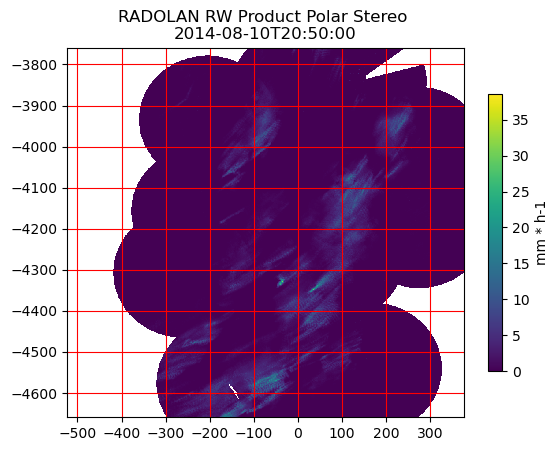

In [5]:
# plot function
plt.pcolormesh(x, y, rwdata, cmap="viridis")
cb = plt.colorbar(shrink=0.75)
cb.set_label("mm * h-1")
plt.title("RADOLAN RW Product Polar Stereo \n" + rwattrs["datetime"].isoformat())
plt.grid(color="r")

A much more comprehensive section using several RADOLAN composites is shown in chapter [RADOLAN Product Showcase](radolan_showcase.ipynb).

## RADOLAN Xarray backend

From wradlib version 1.10.0 a RADOLAN xarray backend is available. RADOLAN data will be imported into an `xarray.Dataset` with attached coordinates.

In [6]:
# load radolan files
rw_filename = wrl.util.get_wradlib_data_file(
    "radolan/misc/raa01-rw_10000-1408102050-dwd---bin.gz"
)
ds = wrl.io.open_radolan_dataset(rw_filename)
# print the xarray dataset
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (y: 900, x: 900, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 8B 2014-08-10T20:50:00
  * y        (y) float64 7kB -4.658e+06 -4.657e+06 ... -3.76e+06 -3.759e+06
  * x        (x) float64 7kB -5.23e+05 -5.22e+05 -5.21e+05 ... 3.75e+05 3.76e+05
Data variables:
    RW       (y, x) float32 3MB ...
Attributes:
    radarid:         10000
    formatversion:   3
    radolanversion:  2.13.1
    radarlocations:  ['boo', 'ros', 'emd', 'hnr', 'umd', 'pro', 'ess', 'asd',...

### Simple Plot

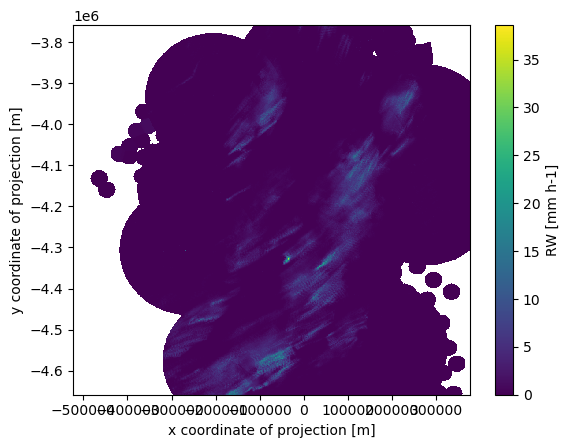

In [7]:
ds.RW.plot()

### Simple selection

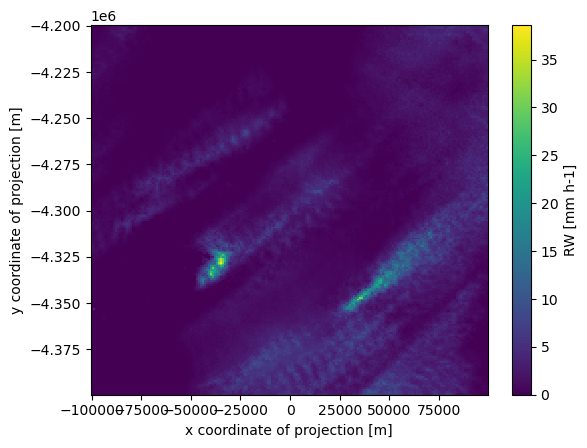

In [8]:
ds.RW.sel(x=slice(-100000, 100000), y=slice(-4400000, -4200000)).plot()

### Map plot using `cartopy`

In [9]:
import cartopy.crs as ccrs

map_proj = ccrs.Stereographic(
    true_scale_latitude=60.0, central_latitude=90.0, central_longitude=10.0
)

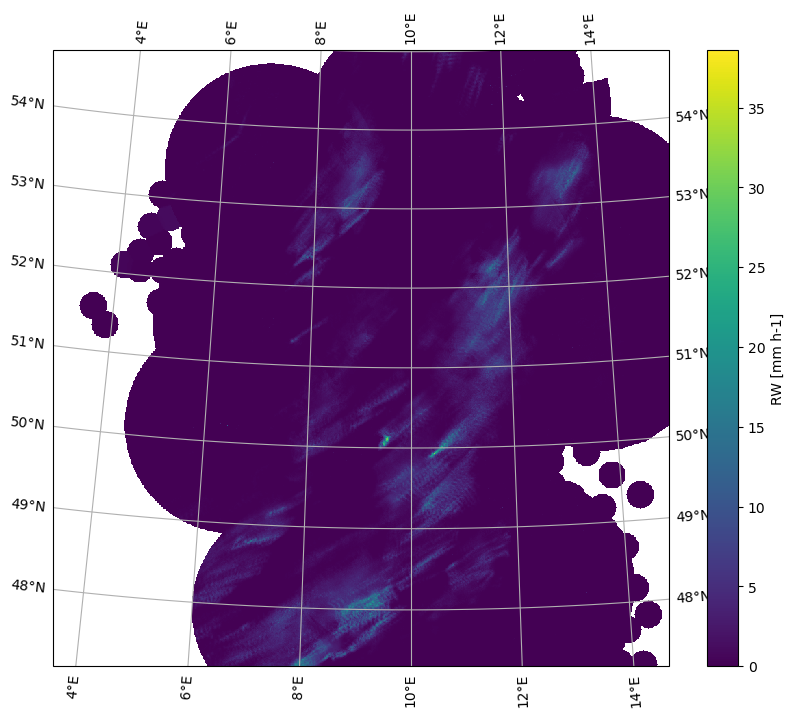

In [10]:
fig = plt.figure(figsize=(10, 8))
ds.RW.plot(subplot_kws=dict(projection=map_proj))
ax = plt.gca()
ax.gridlines(draw_labels=True, y_inline=False)

## Open multiple files

In [11]:
# load radolan files
flist = [
    "radolan/misc/raa01-sf_10000-1305270050-dwd---bin.gz",
    "radolan/misc/raa01-sf_10000-1305280050-dwd---bin.gz",
]
sf_filenames = [wrl.util.get_wradlib_data_file(f) for f in flist]
ds = wrl.io.open_radolan_mfdataset(sf_filenames)
# print the xarray dataset
ds

<xarray.Dataset> Size: 6MB
Dimensions:  (time: 2, y: 900, x: 900)
Coordinates:
  * time     (time) datetime64[ns] 16B 2013-05-27T00:50:00 2013-05-28T00:50:00
  * y        (y) float64 7kB -4.658e+06 -4.657e+06 ... -3.76e+06 -3.759e+06
  * x        (x) float64 7kB -5.23e+05 -5.22e+05 -5.21e+05 ... 3.75e+05 3.76e+05
Data variables:
    SF       (time, y, x) float32 6MB dask.array<chunksize=(1, 900, 900), meta=np.ndarray>
Attributes:
    radarid:         10000
    formatversion:   3
    radolanversion:  2.12.0
    radarlocations:  ['ham', 'ros', 'emd', 'han', 'bln', 'ess', 'fld', 'drs',...
    radardays:       ['bln 24', 'drs 24', 'eis 24', 'emd 24', 'ess 24', 'fld ...

<Figure size 1000x500 with 0 Axes>

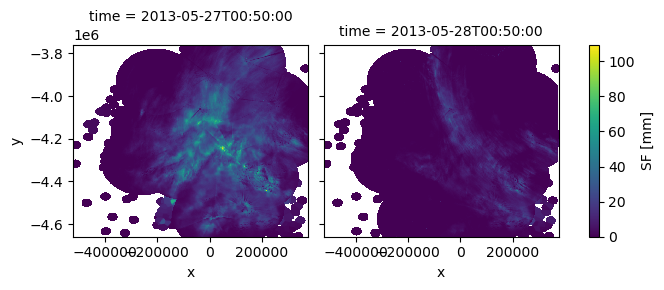

In [12]:
fig = plt.figure(figsize=(10, 5))
ds.SF.plot(col="time")

## Use `xr.open_dataset` and `xr.open_mfdataset`

In [13]:
rw_filename = wrl.util.get_wradlib_data_file(
    "radolan/misc/raa01-rw_10000-1408102050-dwd---bin.gz"
)
ds = xr.open_dataset(rw_filename, engine="radolan")
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (y: 900, x: 900, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 8B 2014-08-10T20:50:00
  * y        (y) float64 7kB -4.658e+06 -4.657e+06 ... -3.76e+06 -3.759e+06
  * x        (x) float64 7kB -5.23e+05 -5.22e+05 -5.21e+05 ... 3.75e+05 3.76e+05
Data variables:
    RW       (y, x) float32 3MB ...
Attributes:
    radarid:         10000
    formatversion:   3
    radolanversion:  2.13.1
    radarlocations:  ['boo', 'ros', 'emd', 'hnr', 'umd', 'pro', 'ess', 'asd',...

In [14]:
sf_filename = os.path.join(
    wrl.util.get_wradlib_data_path(), "radolan/misc/raa01-sf_10000-1305*"
)
ds = xr.open_mfdataset(sf_filename, engine="radolan")
ds

<xarray.Dataset> Size: 6MB
Dimensions:  (time: 2, y: 900, x: 900)
Coordinates:
  * time     (time) datetime64[ns] 16B 2013-05-27T00:50:00 2013-05-28T00:50:00
  * y        (y) float64 7kB -4.658e+06 -4.657e+06 ... -3.76e+06 -3.759e+06
  * x        (x) float64 7kB -5.23e+05 -5.22e+05 -5.21e+05 ... 3.75e+05 3.76e+05
Data variables:
    SF       (time, y, x) float32 6MB dask.array<chunksize=(1, 900, 900), meta=np.ndarray>
Attributes:
    radarid:         10000
    formatversion:   3
    radolanversion:  2.12.0
    radarlocations:  ['ham', 'ros', 'emd', 'han', 'bln', 'ess', 'fld', 'drs',...
    radardays:       ['bln 24', 'drs 24', 'eis 24', 'emd 24', 'ess 24', 'fld ...